In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
# import torch


from tensorflow.keras.backend import clear_session
clear_session()

import time



# import tensorflow_datasets as tfds
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import mixed_precision as mixed_precision


from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten,Dropout, GlobalAveragePooling2D
from keras.models import Model,Sequential
from keras.utils import model_to_dot, plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score, precision_score,recall_score, f1_score
from sklearn.svm import SVC

2024-06-03 07:36:31.856745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 07:36:31.856812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 07:36:31.857886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:


# Set environment variables
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


# Data Loading


In [3]:

from PIL import Image 
  
def load_data(path):
    '''
    Load in the dataset from its home path. Path should be a string of the path
    to the home directory the dataset is found in. Should return a numpy array
    with paired images and class labels.

    Load in the dataset from the path parameter provided. 
    '''

    #Path: C:\Users\brian\OneDrive\QUT\Year 3, Sem2\CAB320\Assignment 2\small_flower_dataset 

    #initialize the dataset to be filled
    X_data = []
    Y_data = np.array([])

    class_lab_int = -1

    #loop over all class specific directories in the path parameter
    for directory in os.listdir(path):

        #record the class label as the directory name
        directory_path = os.path.join(path, directory)
        class_label = os.path.basename(directory_path)
        class_lab_int = class_lab_int + 1

        #loop of files in class specific directory
        for file in os.listdir(directory_path):

            try:
                #open the currently indexed image
                img = Image.open(os.path.join(directory_path, file))

                #resize the current image to (224,224) pixels
                sized_img = img.resize((128,128))

                #convert the resized image to a numpy array
                img_as_array = np.asarray(sized_img)

                #append image and label to dataset
                X_data.append(img_as_array)
                Y_data = np.append(Y_data, int(class_lab_int))
            except:
                pass

    return [X_data, Y_data]

In [4]:
# dataset = load_data('../Assesment3/New_data/')


In [5]:


# with open('dataset.pickle', 'wb') as output:
#     pickle.dump(dataset, output)

# Data Pre-processing


In [6]:
with open('dataset.pickle', 'rb') as data:
    dataset = pickle.load(data)

In [7]:
x_data, y_data = dataset

# print(len(x_data))
# print(len(x_data[0]))
# print(len(x_data[0][0]))
# print(len(x_data[0][0][0]))

# print(x_data[1].shape)


for x in range(len(x_data)-1):
    #print(x)
    if not x_data[x].shape == (128, 128, 3):
        del x_data[x]
        y_data = np.delete(y_data, x)
        #print(x)

x_array = np.array(x_data)
y_array = np.array(y_data)

print(x_array.shape)
print(y_array.shape)

# #big data (not working)
# # x_train = np.concatenate((x_array[0:799], x_array[1000:1799], x_array[2000:2799], x_array[3000:3799], x_array[4000:4799], x_array[5000:5799], x_array[6000:6799], x_array[7000:7799], x_array[8000:8799], x_array[9000:9799]), axis=0)
# # y_train = np.concatenate((y_array[0:799], y_array[1000:1799], y_array[2000:2799], y_array[3000:3799], y_array[4000:4799], y_array[5000:5799], y_array[6000:6799], y_array[7000:7799], y_array[8000:8799], y_array[9000:9799]), axis=0)
# # x_test = np.concatenate((x_array[800:999], x_array[1800:1999], x_array[2800:2999], x_array[3800:3999], x_array[4800:4999], x_array[5800:5999], x_array[6800:6999], x_array[7800:7999], x_array[8800:8999], x_array[9800:9999]), axis=0)
# # y_test = np.concatenate((y_array[800:999], y_array[1800:1999], y_array[2800:2999], y_array[3800:3999], y_array[4800:4999], y_array[5800:5999], y_array[6800:6999], y_array[7800:7999], y_array[8800:8999], y_array[9800:9999]), axis=0)
# #small data 2 class (working)
# # x_train = np.concatenate((x_array[0:399], x_array[1000:1399]), axis=0)
# # y_train = np.concatenate((y_array[0:399], y_array[1000:1399]), axis=0)
# # x_test = np.concatenate((x_array[400:499], x_array[1400:1499]), axis=0)
# # y_test = np.concatenate((y_array[400:499], y_array[1400:1499]), axis=0)
# # #small data all class (not working)
# # x_train = np.concatenate((x_array[0:399], x_array[1000:1399], x_array[2000:2399], x_array[3000:3399], x_array[4000:4399], x_array[5000:5399], x_array[6000:6399], x_array[7000:7399], x_array[8000:8399], x_array[9000:9399]), axis=0)
# # y_train = np.concatenate((y_array[0:399], y_array[1000:1399], y_array[2000:2399], y_array[3000:3399], y_array[4000:4399], y_array[5000:5399], y_array[6000:6399], y_array[7000:7399], y_array[8000:8399], y_array[9000:9399]), axis=0)
# # x_test = np.concatenate((x_array[400:499], x_array[1400:1499], x_array[2400:2499], x_array[3400:3499], x_array[4400:4499], x_array[5400:5499], x_array[6400:6499], x_array[7400:7499], x_array[8400:8499], x_array[9400:9499]), axis=0)
# # y_test = np.concatenate((y_array[400:499], y_array[1400:1499], y_array[2400:2499], y_array[3400:3499], y_array[4400:4499], y_array[5400:5499], y_array[6400:6499], y_array[7400:7499], y_array[8400:8499], y_array[9400:9499]), axis=0)

# #small data all class
# x_train = np.concatenate((x_array[0:299], x_array[1000:1299], x_array[2000:2399], x_array[3000:3399], x_array[4000:4399], x_array[5000:5399], x_array[6000:6399], x_array[7000:7399], x_array[8000:8399], x_array[9000:9399]), axis=0)
# y_train = np.concatenate((y_array[0:299], y_array[1000:1299], y_array[2000:2399], y_array[3000:3399], y_array[4000:4399], y_array[5000:5399], y_array[6000:6399], y_array[7000:7399], y_array[8000:8399], y_array[9000:9399]), axis=0)
# x_test = np.concatenate((x_array[300:399], x_array[1300:1399], x_array[2400:2499], x_array[3400:3499], x_array[4400:4499], x_array[5400:5499], x_array[6400:6499], x_array[7400:7499], x_array[8400:8499], x_array[9400:9499]), axis=0)
# y_test = np.concatenate((y_array[300:399], y_array[1300:1399], y_array[2400:2499], y_array[3400:3499], y_array[4400:4499], y_array[5400:5499], y_array[6400:6499], y_array[7400:7499], y_array[8400:8499], y_array[9400:9499]), axis=0)



# tensor_x_train = torch.tensor(x_train.astype(np.float32))
# tensor_y_train = torch.tensor(y_train.astype(np.float32))
# tensor_x_test = torch.tensor(x_test.astype(np.float32))
# tensor_y_test = torch.tensor(y_test.astype(np.float32))




(9999, 128, 128, 3)
(9999,)


In [8]:
import numpy as np

def create_train_test_splits(x_array, y_array, train_slices, test_slices):
    """
    Create training and testing datasets based on provided slices.

    Parameters:
    - x_array: numpy array of features.
    - y_array: numpy array of labels.
    - train_slices: list of tuples, each specifying a slice for training data.
    - test_slices: list of tuples, each specifying a slice for testing data.

    Returns:
    - x_train, y_train: numpy arrays for training features and labels.
    - x_test, y_test: numpy arrays for testing features and labels.
    """
    x_train = np.concatenate([x_array[start:end] for start, end in train_slices], axis=0)
    y_train = np.concatenate([y_array[start:end] for start, end in train_slices], axis=0)
    x_test = np.concatenate([x_array[start:end] for start, end in test_slices], axis=0)
    y_test = np.concatenate([y_array[start:end] for start, end in test_slices], axis=0)
    
    return x_train, y_train, x_test, y_test

# Define slices for training and testing
train_slices = [(0, 799), (1000, 1799), (2000, 2799), (3000, 3799), 
                (4000, 4799), (5000, 5799), (6000, 6799), (7000, 7799), 
                (8000, 8799), (9000, 9799)]

test_slices = [(800, 999), (1800, 1999), (2800, 2999), (3800, 3999), 
               (4800, 4999), (5800, 5999), (6800, 6999), (7800, 7999), 
               (8800, 8999), (9800, 9999)]

x_train, y_train, x_test, y_test = create_train_test_splits(x_array, y_array, train_slices, test_slices)

x_array = []
y_array = []


In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7990, 128, 128, 3)
(7990,)
(1990, 128, 128, 3)
(1990,)


In [10]:
# Normalize the image data
x_train = x_train / 255.0
x_test = x_test / 255.0

# # Optionally, apply data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True
# )


In [11]:
# x_data, y_data = dataset

# # Convert labels to categorical
# y_data = tf.keras.utils.to_categorical(y_data, num_classes=10)

# # Splitting the dataset
# split_index = int(0.8 * len(x_data))
# x_train, x_test = x_data[:split_index], x_data[split_index:]
# y_train, y_test = y_data[:split_index], y_data[split_index:]

# # Convert to TensorFlow tensors
# tensor_x_train = torch.tensor(x_train.astype(np.float32))
# tensor_y_train = torch.tensor(y_train.astype(np.float32))
# tensor_x_test = torch.tensor(x_test.astype(np.float32))
# tensor_y_test = torch.tensor(y_test.astype(np.float32))


# print(f"tensor_x_train shape: {tensor_x_train.shape}")
# print(f"tensor_y_train shape: {tensor_y_train.shape}")
# print(f"tensor_x_test shape: {tensor_x_test.shape}")
# print(f"tensor_y_test shape: {tensor_y_test.shape}")

## Data Augmentation 

# CNN model

In [12]:


#Defining CallBack list

callback_list=[
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

In [13]:
# def MobileNetV2_model(input_shape,class_number):
#     baseModel = MobileNetV2(include_top=False, input_shape=input_shape)
#     baseModel.trainable = False 
   
#     model = Sequential()
#     model.add(baseModel)
#     model.add(GlobalAveragePooling2D())
#     model.add(Flatten())
#     model.add(Dense(512, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(50, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(class_number, activation='softmax'))

#     return model

In [14]:
#Constant
bs = 64
lr = 0.0001
size = (128, 128)

shape = (128,128, 3) 
epochs = 10
class_number = 10



In [15]:
mobile_base = MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)


inputs = Input(shape=(128,128,3))
x = mobile_base(inputs, training=False)
x_pool = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x_pool)    
x = Flatten()(x)
x = Dense(units=1024, activation="relu")(x)
x = Dropout(0.3)(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x) 
x = Dense(50, activation='relu')(x)
outputs = Dense(class_number, activation='softmax')(x)

In [16]:

model_m = Model(inputs=inputs, outputs=outputs)
model_m.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,239,216 (16.17 MB)

 Trainable params: 4,205,104 (16.04 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [17]:
# plot_model(model_m, show_shapes=True, dpi=60)

In [18]:
# Instantiate and compile the modelclass_number
# model = MobileNetV2_model(shape,class_number )



model_m.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)




In [19]:
start_time = time.time()
print("batch_size :",bs)
# Train the model
history = model_m.fit(
    x_train,
    y_train,
    batch_size= bs,
    epochs=10,
    verbose=1,
    #callbacks=callback_list,
    validation_data=(x_test, y_test)
)

cnn_train_time = time.time() - start_time

batch_size : 64
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1730s 14s/step - accuracy: 0.3588 - loss: 1.8148 - val_accuracy: 0.2216 - val_loss: 4.3646
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1711s 14s/step - accuracy: 0.7038 - loss: 0.9830 - val_accuracy: 0.1392 - val_loss: 10.0869
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1707s 14s/step - accuracy: 0.7466 - loss: 0.8327 - val_accuracy: 0.1437 - val_loss: 11.3674
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1705s 14s/step - accuracy: 0.8116 - loss: 0.6263 - val_accuracy: 0.1487 - val_loss: 10.6517
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1704s 14s/step - accuracy: 0.8237 - loss: 0.5916 - val_accuracy: 0.2412 - val_loss: 5.7436
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1703s 14s/step - accuracy: 0.8374 - loss: 0.5696 - val_accuracy: 0.1151 - val_loss: 10.3515
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1702s 14s/step - accuracy: 0.8695 - loss: 0.4483 - val_accuracy: 0.1709 - val_loss: 8.8105
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1707s 14s/step - accura

NameError: name 'cnn_train_time' is not defined

In [20]:
# # Train the model
# try:
#     history = model_m.fit(x_train, y_train, epochs=10, batch_size=bs, validation_data=(x_test, y_test))
# except tf.errors.InternalError as e:
#     print("Switching to CPU due to GPU memory issues")
#     with tf.device('/CPU:0'):
#         history = model_m.fit(x_train, y_train, epochs=10, batch_size=bs, validation_data=(x_test, y_test))

In [21]:
# feature_extractor = Model(inputs=model_m.input, outputs=model_m.layers[-4].output)
# feature_extractor.summary()


In [22]:
# # Extract features from the training data
# train_features = feature_extractor.predict(x_train)
# # Extract features from the testing data
# test_features = feature_extractor.predict(x_test)

In [23]:
# # Train an SVM classifier
# svm = SVC(kernel='linear')
# svm.fit(train_features, y_train)

# Evaluation 1

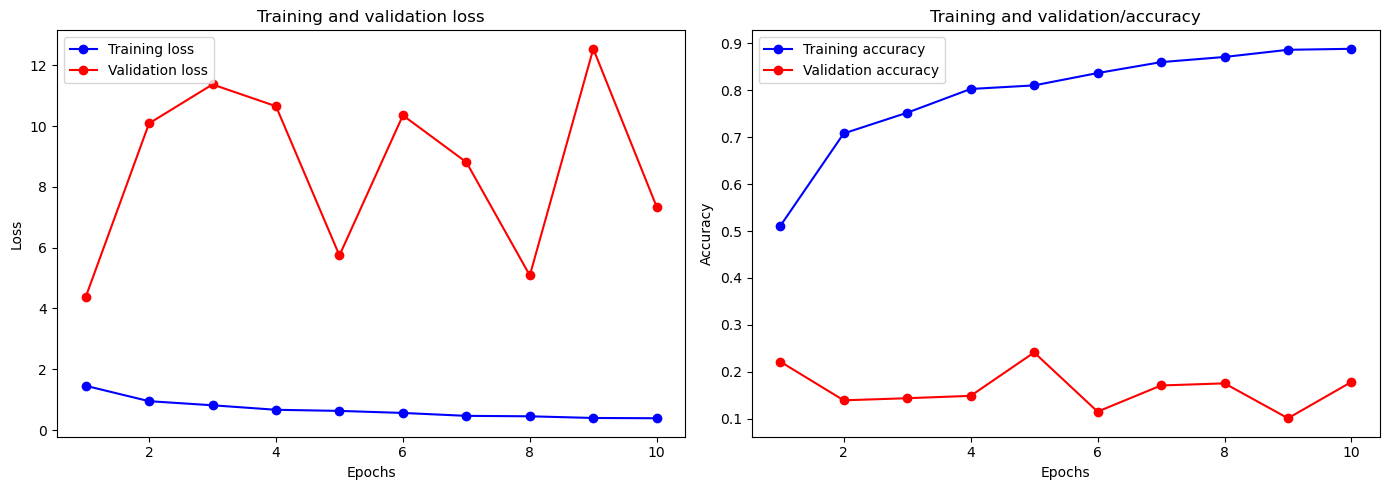

In [24]:
def plot_loss_and_accuracy(history):
    """
    Plots the loss and accuracy from the training history.
    
    Parameters:
    history: History object returned by the `fit` method of a Keras model.
    """
    # Get the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)
    
    # Plot loss
    plt.figure(figsize=(14, 5))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training and validation/accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_loss_and_accuracy(history)

63/63 - 34s - 535ms/step - accuracy: 0.1789 - loss: 7.2588
Test accuracy: 0.17889447510242462


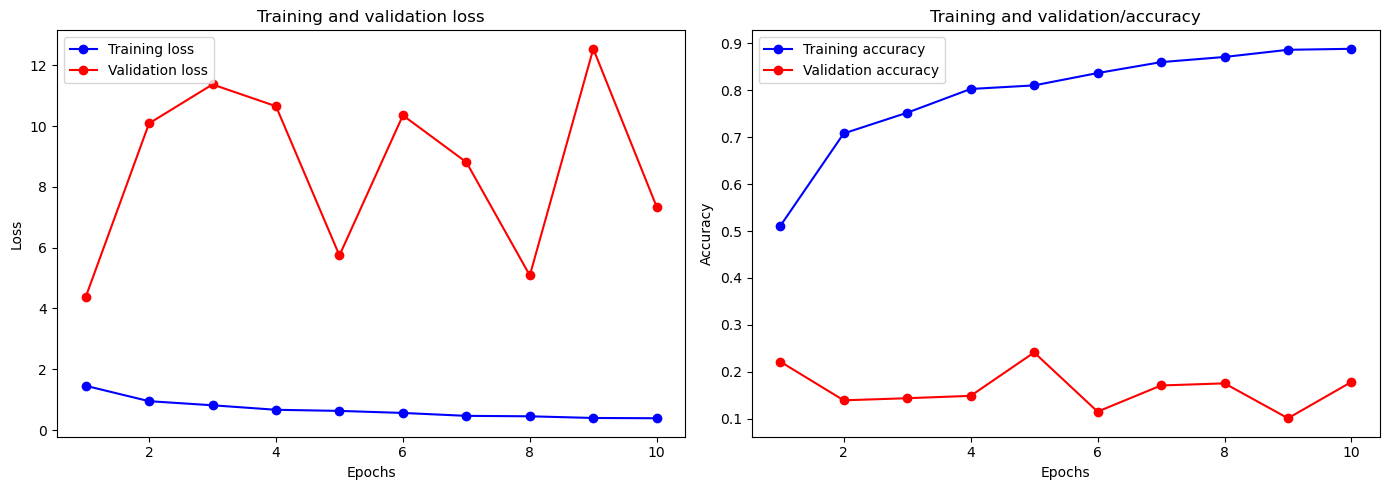

In [25]:
# Evaluate the model on the test data
test_loss, test_acc = model_m.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')
plot_loss_and_accuracy(history)

In [26]:
start_time = time.time()
y_pred = np.argmax(model_m.predict(x_test), axis=1)
cnn_test_time = time.time() - start_time

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 547ms/step


In [27]:
# Calculate classification metrics
classification_accuracy = accuracy_score(y_test, y_pred)
classification_precision = precision_score(y_test, y_pred, average='weighted')
classification_recall = recall_score(y_test, y_pred, average='weighted')
classification_f1 = f1_score(y_test, y_pred, average='weighted')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Metrics:
Accuracy: 0.17889447236180905
Precision: 0.24731040961469664
Recall: 0.17889447236180905
F1-Score: 0.0935234713004256
Confusion Matrix:
[[ 38   0  43   0   0   0 118   0   0   0]
 [ 20   1  63   0   0   1 114   0   0   0]
 [  1   0 124   0   0   0  74   0   0   0]
 [ 14   0   9   0   1   0 175   0   0   0]
 [ 27   0  10   0   6   0 156   0   0   0]
 [ 17   0  46   0   0   1 135   0   0   0]
 [ 10   0   3   0   0   0 186   0   0   0]
 [ 51   0  16   0   1   0 131   0   0   0]
 [ 54   0   6   0   4   0 135   0   0   0]
 [ 36   0  23   0   0   1 139   0   0   0]]


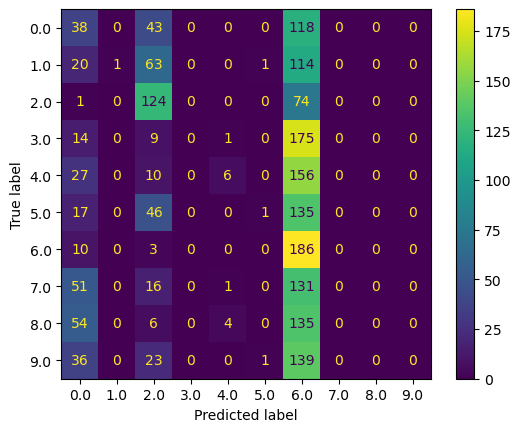

In [28]:
print("Classification Metrics:")
print(f"Accuracy: {classification_accuracy}")
print(f"Precision: {classification_precision}")
print(f"Recall: {classification_recall}")
print(f"F1-Score: {classification_f1}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
confusion_matrix_display.plot()
plt.show()

# Evaluation 2

In [29]:
# # Predict the labels on the test set
# y_pred = svm.predict(test_features)

# # Calculate classification metrics
# classification_accuracy = accuracy_score(y_test, y_pred)
# classification_precision = precision_score(y_test, y_pred, average='weighted')
# classification_recall = recall_score(y_test, y_pred, average='weighted')
# classification_f1 = f1_score(y_test, y_pred, average='weighted')

# print("Classification Metrics:")
# print(f"Accuracy: {classification_accuracy}")
# print(f"Precision: {classification_precision}")
# print(f"Recall: {classification_recall}")
# print(f"F1-Score: {classification_f1}")

# # Confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:")
# print(cm)

# # Plot confusion matrix
# confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
# confusion_matrix_display.plot()
# plt.show()
